In [1]:
import tensorflow as tf

import os
import sys
import numpy as np
from scipy.io import savemat
from sklearn.linear_model import SGDClassifier

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append(os.path.abspath('helper'))
# import utils
# import loader
import utils_GAN_FiLM, PAD

2025-08-03 10:01:15.453494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754229675.468142   31410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754229675.472509   31410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754229675.483922   31410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754229675.483936   31410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754229675.483938   31410 computation_placer.cc:177] computation placer alr

In [2]:
notebook_dir = os.getcwd()
print(notebook_dir)
print(os.path.abspath(os.path.join(notebook_dir, '..', '..')))
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..', '..')))
import Est_btween_CSIRS.helper.utils as utils_CNN
import Est_btween_CSIRS.helper.loader as loader
import Est_btween_CSIRS.helper.plotfig as plotfig

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Domain_Adaptation/Domain_Adversarial
/home/thien/Code/H_predict_UDA/H_predict_Sionna


In [3]:
# # Generate a (16, 792, 14, 2) matrix with random values
# random_matrix = np.random.randn(16, 792, 14, 2)
# random_matrix.shape

# random_matrix2 = np.random.randn(16, 792, 1, 2)

# genGAN = utils_GAN_FiLM.Pix2PixFiLMGenerator()
# test_est, test_extract = genGAN(random_matrix, random_matrix2)

# print(test_est.shape)
# print(test_extract.shape)

# discGAN = utils_GAN_FiLM.PatchGANDiscriminator()
# test_disc = discGAN(test_est)
# print(test_disc.shape)

# discDomain = utils_GAN_FiLM.DomainDiscriminator3()
# test_disc_domain = discDomain(test_extract)
# print(test_disc_domain.shape)


In [4]:
# GAN_model = utils_GAN_FiLM.GAN_FiLM()
# out_put = GAN_model((random_matrix, random_matrix2))
# print(out_put.gen_out.shape)
# print(out_put.disc_out.shape)
# print(out_put.extracted_features.shape)

In [5]:
source_data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'CDL_Channel', 'generatedChannel', 'ver3_', '0dB', 'mapBaseData.mat'))
target_data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'Sionna', 'generatedChannel', 'ver3_', 'sionnaTrue.mat'))

In [6]:
learning_rate = 0.0001
norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
adv_weight=0.01
est_weight=1
domain_weight=0 # 0.5 for Domain Discriminator, 0 for no Domain Discriminator

# snr_start = -25
# snr_step = 5
# snr_end = 25
# SNR = np.arange(snr_start, snr_end+1, snr_step)

# SNR = np.array([0])

# if len(SNR) >1:
#     SNR_txt = f'{snr_start}:{snr_step}:{snr_end}'
# else:
#     SNR_txt = f'{SNR[0]}'
    
# ============ CNN settings ==============
if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    
CNN_activation = 'Tanh'
CNN_DropOut = 0.2
if CNN_DropOut != 0:
    dropOut_txt = f'Add p={CNN_DropOut} DropOut'
    
# ============ Adversarial for Domain Discriminator settings ==============
lambda_domain=0.1
lambda_domain_cond = 0.1
text_lambda = f'lambda_domain = {lambda_domain}'
    
    
# # create readme.txt file
# content = f"""Generated by file 'Domain_Adversarial/UDA_CNN_v3.ipynb'.
# 28 GHz fc,
# Source dataset got from {source_data_file_path},
# Target dataset got from {target_data_file_path},
# Learning rate {learning_rate},
# {norm_txt} scaler for each sample
# Using {CNN_activation} as activation function of CNN
# {dropOut_txt}
# ========= For Domain Discriminator ==========
# Extract features after layer {extract_layer} of CNN
# {text_lambda}
# """

In [7]:
# Paths to save
idx_save_path = loader.find_incremental_filename(notebook_dir + '/model/GAN','ver', '_', '')

save_model = 0
model_path = notebook_dir + '/model/GAN/ver' + str(idx_save_path) + '_'
# figure_path = notebook_dir + '/model/GAN/ver' + str(idx_save_path) + '_/figure'
model_readme = model_path + '/readme.txt'
# figure_readme = figure_path + '/readme.txt'

# if not os.path.exists(os.path.dirname(model_readme)):
#     os.makedirs(os.path.dirname(model_readme))
# # if not os.path.exists(os.path.dirname(figure_readme)):
# #     os.makedirs(os.path.dirname(figure_readme))

# # Open the file in write mode ('w'). If the file does not exist, it will be created.
# with open(model_readme, 'w') as file:
#     # Write the content to the file
#     file.write(content)

# # with open(figure_readme, 'w') as file:
# #     # Write the content to the file
# #     file.write(content)

# print(f"File '{model_readme}'  created and content written.")


In [8]:
import h5py

batch_size=16

# ============ Source data ==============
source_file = h5py.File(source_data_file_path, 'r')
H_true_source = source_file['H_true']
N_samp_source = H_true_source.shape[0]
print('N_samp_source = ', N_samp_source)

# ============ Target data ==============
target_file = h5py.File(target_data_file_path, 'r')
H_true_target = target_file['H_true']
N_samp_target = H_true_target.shape[0]
print('N_samp_target = ', N_samp_target)

N_samp_source =  2048
N_samp_target =  2048


In [9]:
indices_source = np.arange(N_samp_source)
np.random.shuffle(indices_source)
indices_target = np.arange(N_samp_target)
np.random.shuffle(indices_target)
#
train_size = int(np.floor(N_samp_source * 0.9) // batch_size * batch_size)
val_size = N_samp_source - train_size

# Repeat the indices to match the maximum number of samples
N_samp = max(N_samp_source, N_samp_target) 
indices_source = np.resize(indices_source, N_samp)
indices_target = np.resize(indices_target, N_samp)

# =======================================================
## Divide the indices into training and validation sets
indices_train_source = indices_source[:train_size]
indices_val_source   = indices_source[train_size:train_size + val_size]

indices_train_target = indices_target[:train_size]
indices_val_target   = indices_target[train_size:train_size + val_size]

# to test code
# indices_train_source = indices_source[:96]
# indices_val_source = indices_source[2032:]
# indices_train_target = indices_target[:96]
# indices_val_target = indices_target[2032:]

print('train_size = ', indices_train_source.shape[0])
print('val_size = ', indices_val_source.shape[0])

train_size =  1840
val_size =  208


In [10]:
# =========== Source dataset ==============
loader_H_true_train_source = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train_source)
loader_H_1_6_11_train_source = utils_CNN.H5BatchLoader(source_file, 'H_linear_1_6_11', batch_size=batch_size, shuffled_indices=indices_train_source)
    # channel at symbol 2 of slots 1,6,11 (channel corresponding to CSI-RS 1, 2, 3)
loader_H_true_val_source = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val_source)
loader_H_1_6_11_val_source = utils_CNN.H5BatchLoader(source_file, 'H_linear_1_6_11', batch_size=batch_size, shuffled_indices=indices_val_source)

# =========== Target dataset ==============
loader_H_true_train_target = utils_CNN.H5BatchLoader(target_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train_target)
    # actually at target domain, we don't have true channels, just use this for evaluating the model
loader_H_1_6_11_train_target = utils_CNN.H5BatchLoader(target_file, 'H_linear_1_6', batch_size=batch_size, shuffled_indices=indices_train_target)
    # channel at symbol 2 of slots 1,6,11 (channel corresponding to CSI-RS 1, 2)
loader_H_true_val_target = utils_CNN.H5BatchLoader(target_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val_target)
loader_H_1_6_11_val_target = utils_CNN.H5BatchLoader(target_file, 'H_linear_1_6', batch_size=batch_size, shuffled_indices=indices_val_target)

print('size loader_H_true_train = ', loader_H_true_train_target.total_batches)
print('size loader_H_true_val = ', loader_H_true_val_target.total_batches)

size loader_H_true_train =  115
size loader_H_true_val =  13


In [11]:
# Calculate PAD for original datasets with SVM
# pad = PAD.original_PAD(loader_H_1_6_11_train_source, loader_H_1_6_11_train_target)
# print(f"PAD = {pad:.4f}")

In [12]:
loss_fn_ce = tf.keras.losses.MeanSquaredError()  # Channel estimation loss (generator loss)
loss_fn_bce = tf.keras.losses.BinaryCrossentropy(from_logits=False) # Binary cross-entropy loss for discriminator
loss_fn_domain = tf.keras.losses.BinaryCrossentropy()  # Domain classification loss

In [13]:
import time
start = time.perf_counter()

n_epochs= 300
epoch_min = 50
epoch_step = 80
# n_epochs= 3
# epoch_min = 0
# epoch_step = 1

train_mode = ['FiLM']

for sub_folder in train_mode:
    print(f"Processing: {sub_folder}")
    
    if not os.path.exists(os.path.dirname(model_path + '/' + sub_folder +'/')):
        os.makedirs(os.path.dirname(model_path + '/' + sub_folder + '/'))

    train_loss          = [] # (epoch,1)
    train_est_loss      = [] 
    train_domain_loss   = []
    train_est_loss_target = []
    #    
    val_loss, val_gan_disc_loss, val_domain_disc_loss,\
    val_est_loss_source, val_est_loss_target, val_est_loss,\
    source_acc, target_acc, acc,\
    nmse_val_source, nmse_val_target, nmse_val = [[] for _ in range(12)]
    #
    H_to_save = {}          # list to save to .mat file for H
    perform_to_save = {}    # list to save to .mat file for nmse, losses,...

    model = utils_GAN_FiLM.GAN_FiLM()
    model_domain = utils_GAN_FiLM.DomainDiscriminator3()
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    domain_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    ####
    optimizer = [gen_optimizer, disc_optimizer, domain_optimizer]
    ####
    
    flag = 1 # flag to plot and save H_true
    pad_observe = [] # pad observation over epochs
    epoc_pad = []    # epochs that calculating pad (return_features == True)
    for epoch in range(n_epochs):
        # ===================== Training =====================
        loader_H_true_train_source.reset()
        loader_H_1_6_11_train_source.reset()
        loader_H_true_train_target.reset()
        loader_H_1_6_11_train_target.reset()
                
        loader_H = [loader_H_1_6_11_train_source, loader_H_true_train_source, loader_H_1_6_11_train_target, loader_H_true_train_target]
        loss_fn = [loss_fn_ce, loss_fn_bce, loss_fn_domain]
    
        ##########################
        if epoch in [int(n_epochs * r) for r in [0.25, 0.5, 0.75, 1.0]]:
            # return_features == return features to calculate PAD
            return_features = True
            epoc_pad.append(epoch)
        else:
            return_features = False

        ##########################
        train_step_output = utils_GAN_FiLM.train_step_gan(model, model_domain, loader_H, loss_fn, optimizer, lower_range=-1,
                                adv_weight=adv_weight, est_weight=est_weight, domain_weight=domain_weight, return_features=return_features)
        
        train_epoc_loss_est        = train_step_output.avg_epoc_loss_est
        train_epoc_loss_domain     = train_step_output.avg_epoc_loss_domain
        train_epoc_loss            = train_step_output.avg_epoc_loss
        train_epoc_loss_est_target = train_step_output.avg_epoc_loss_est_target
                # train_epoc_loss        = total train loss = loss_est + lambda_domain * domain_loss
                # train_epoc_loss_est    = loss in estimation network in source domain (labels available)
                # train_epoc_loss_domain = loss in domain discrimination network
                # train_epoc_loss_est_target - just to monitor - the machine can not calculate because no label available in source domain
                # All are already calculated in average over training dataset (source/target - respectively)
        print("Time", time.perf_counter() - start, "seconds")
        # Calculate PAD for the extracted features
        if return_features:
            features_source_file = "features_source.h5"
            features_target_file = "features_target.h5"
            print(f"epoch {epoch+1}/{n_epochs}")
            # pad_epoc_sgd  = PAD.cal_PAD_SGD(features_source_file, features_target_file)
            pad_epoc  = PAD.cal_PAD2(features_source_file, features_target_file, pca_components=100, batch_size=128)
            pad_observe.append(pad_epoc)
            if os.path.exists(features_source_file):
                os.remove(features_source_file)
            if os.path.exists(features_target_file):
                os.remove(features_target_file)
            print("Time", time.perf_counter() - start, "seconds")
            
        
        # Average loss for the epoch
        train_loss.append(train_epoc_loss)
        print(f"epoch {epoch+1}/{n_epochs} Average Training Loss: {train_epoc_loss:.6f}")
        #
        train_est_loss.append(train_epoc_loss_est)
        print(f"epoch {epoch+1}/{n_epochs} Average Estimation Loss (in Source domain): {train_epoc_loss_est:.6f}")
        #
        train_domain_loss.append(train_epoc_loss_domain)
        print(f"epoch {epoch+1}/{n_epochs} Average Domain Discrimination Loss: {train_epoc_loss_domain:.6f}")
        #
        train_est_loss_target.append(train_epoc_loss_est_target)
        print(f"epoch {epoch+1}/{n_epochs} For observation only - Average Estimation Loss in Target domain: {train_epoc_loss_est_target:.6f}")
        
        
        # ===================== Evaluation =====================
        loader_H_true_val_source.reset()
        loader_H_1_6_11_val_source.reset()
        loader_H_true_val_target.reset()
        loader_H_1_6_11_val_target.reset()
        loader_H_eval = [loader_H_1_6_11_val_source, loader_H_true_val_source, loader_H_1_6_11_val_target, loader_H_true_val_target]

        loss_fn = [loss_fn_ce, loss_fn_bce, loss_fn_domain]
        
        # eval_func = utils_UDA_FiLM.val_step
        if (epoch+1>epoch_min and epoch%epoch_step==0) or epoch==n_epochs-1:
            H_sample, epoc_val_return = utils_GAN_FiLM.val_step(model, model_domain, loader_H_eval, loss_fn, lower_range, 
                                                                adv_weight=adv_weight, est_weight=est_weight, domain_weight=domain_weight)
            utils_GAN_FiLM.visualize_H(H_sample, H_to_save, epoch, plotfig.figChan, flag, model_path, sub_folder)
            flag = 0  # after the first epoch, no need to save H_true anymore
            
        else:
            _, epoc_val_return = utils_GAN_FiLM.val_step(model, model_domain, loader_H_eval, loss_fn, lower_range, 
                                                                adv_weight=adv_weight, est_weight=est_weight, domain_weight=domain_weight)
        
        utils_GAN_FiLM.post_val(epoc_val_return, epoch, n_epochs, val_est_loss, val_est_loss_source, val_loss, val_est_loss_target,
            val_gan_disc_loss, val_domain_disc_loss, nmse_val_source, nmse_val_target, nmse_val, source_acc, target_acc, acc)
        
        
        if (epoch+1>epoch_min and (epoch+1)%epoch_step==0) or epoch==n_epochs-1:
            utils_GAN_FiLM.save_checkpoint(model, save_model, model_path, sub_folder, epoch, plotfig.figLoss, savemat, train_loss, train_est_loss, train_domain_loss, train_est_loss_target,
                    val_est_loss, val_est_loss_source, val_loss, val_est_loss_target, val_gan_disc_loss, val_domain_disc_loss,
                    source_acc, target_acc, acc, nmse_val_source, nmse_val_target, nmse_val, pad_observe, epoc_pad)
    
    # end of epoch loop
    # =====================            
    # Save performances
    # Save H matrix
    savemat(model_path + '/' + sub_folder + '/H_visualize/H_trix.mat', H_to_save)
    
    

Processing: FiLM


I0000 00:00:1754229679.818606   31410 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9548 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
I0000 00:00:1754229679.819182   31410 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9548 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
I0000 00:00:1754229679.819708   31410 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9486 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5
I0000 00:00:1754229683.636924   31410 cuda_dnn.cc:529] Loaded cuDNN version 90300


Time 172.69736979500158 seconds
epoch 1/300 Average Training Loss: 0.201677
epoch 1/300 Average Estimation Loss (in Source domain): 0.161712
epoch 1/300 Average Domain Discrimination Loss: 0.073630
epoch 1/300 For observation only - Average Estimation Loss in Target domain: 0.161712
epoch 1/300 (Val) Weighted Total Loss: 0.398946
epoch 1/300 (Val) Average Estimation Loss (mean): 0.238917
epoch 1/300 (Val) Average Estimation Loss (Source): 0.213638
epoch 1/300 (Val) Average Estimation Loss (Target): 0.264196
epoch 1/300 (Val) GAN Discriminator Loss: 16.002903
epoch 1/300 (Val) Domain Discriminator Loss: 0.012474
epoch 1/300 (Val) NMSE (Source): 0.958624, NMSE (Target): 0.886201, NMSE (Mean): 0.922413
epoch 1/300 (Val) Domain Discriminator Accuracy (Average): 0.9976
Time 342.91646998899523 seconds
epoch 2/300 Average Training Loss: 0.188360
epoch 2/300 Average Estimation Loss (in Source domain): 0.135453
epoch 2/300 Average Domain Discrimination Loss: 0.009568
epoch 2/300 For observation

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Est_btween_CSIRS/helper/plotfig.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Time 41983.393081268994 seconds
epoch 241/300 Average Training Loss: 0.094366
epoch 241/300 Average Estimation Loss (in Source domain): 0.013777
epoch 241/300 Average Domain Discrimination Loss: 0.000002
epoch 241/300 For observation only - Average Estimation Loss in Target domain: 0.013777
epoch 241/300 (Val) Weighted Total Loss: 0.292962
epoch 241/300 (Val) Average Estimation Loss (mean): 0.251765
epoch 241/300 (Val) Average Estimation Loss (Source): 0.130261
epoch 241/300 (Val) Average Estimation Loss (Target): 0.373268
epoch 241/300 (Val) GAN Discriminator Loss: 4.119716
epoch 241/300 (Val) Domain Discriminator Loss: 0.028774
epoch 241/300 (Val) NMSE (Source): 1.165568, NMSE (Target): 1.089800, NMSE (Mean): 1.127684
epoch 241/300 (Val) Domain Discriminator Accuracy (Average): 0.9976
Time 42154.106131576 seconds
epoch 242/300 Average Training Loss: 0.094205
epoch 242/300 Average Estimation Loss (in Source domain): 0.013615
epoch 242/300 Average Domain Discrimination Loss: 0.000001
e

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 200x600 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 200x600 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [14]:
pad_observe

[1.9891304347826089, 1.9891304347826089, 1.9869565217391303]

In [15]:
# To check PCA somponents that retains 95% variance

import h5py
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA

with h5py.File("features_source.h5", 'r') as f_source, h5py.File("features_target.h5", 'r') as f_target:
        dset_source = f_source['features']
        dset_target = f_target['features']
        batch_source = dset_source[:]
        batch_target = dset_target[:]
        batch = np.concatenate([batch_source, batch_target], axis=0)
        X_sample = batch.reshape(batch.shape[0], -1)
        pca = PCA()
        pca.fit(X_sample)

        # Find the smallest number of components that explain ≥ 95% variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        k = np.argmax(cumulative_variance >= 0.95) + 1 
        print(f"Number of components to retain 95% variance: {k}") 
        
        # Explained variance ratio per component
        explained_variance_ratio = pca.explained_variance_ratio_
        # Sum of the first 100 components
        variance_100 = np.sum(explained_variance_ratio[:100])
        print(f"Variance retained by first 100 components: {variance_100:.4f} ({variance_100*100:.2f}%)")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'features_source.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

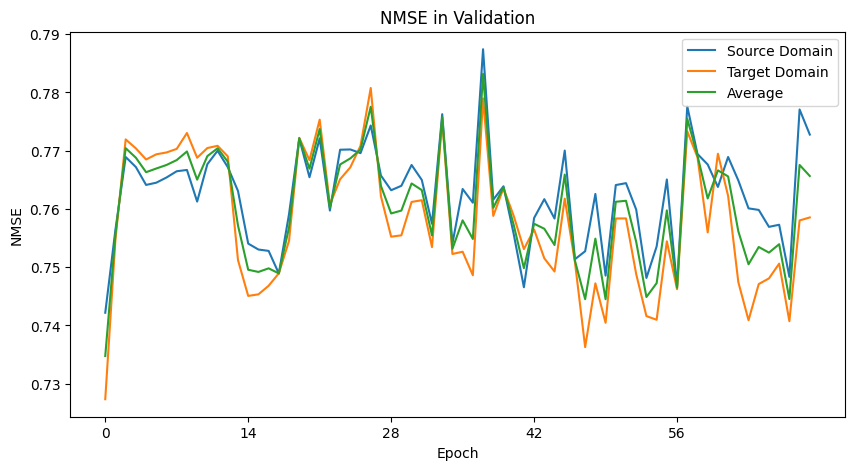

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotfig.figLoss(line_list=[(nmse_val_source, 'Source Domain'), (nmse_val_target, 'Target Domain'), (nmse_val, 'Average')], xlabel='Epoch', ylabel='NMSE',
#                         title='NMSE in Validation', index_save=1, fig_show=True, fig_name='NMSE_val')
            

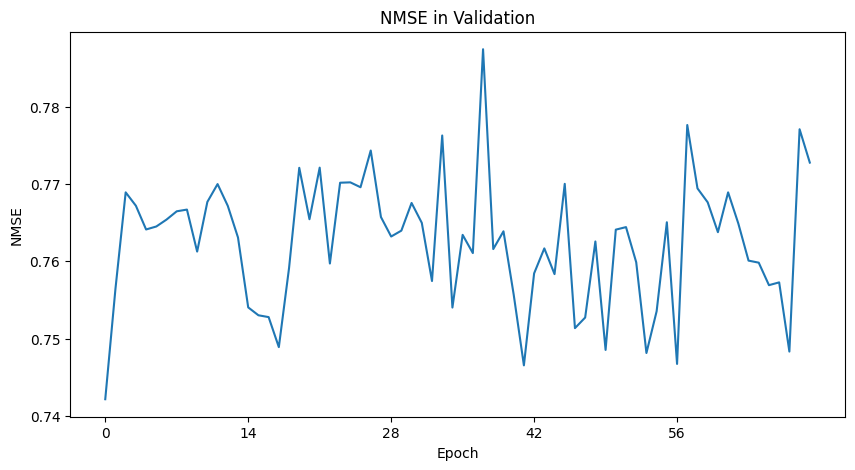

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotfig.figLoss(line_list=[(nmse_val_source, 'Source Domain')], xlabel='Epoch', ylabel='NMSE',
#                         title='NMSE in Validation', index_save=1, fig_show=True, fig_name='NMSE_val')
            